# Regression (ML) and Submission for [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)
---

# 1. Load, Merge and Clean the Dataset

In [1]:
# load all datasets, then merge and clean them to be used:
import lib.clean_db as clean_db

df = clean_db.load_from('data')                 # 'data': directory that contains .csv files


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

df.visit_date = pd.to_datetime(df.visit_date)   # Convert column visit_date to Datetime object

# Dump lat/lon to a CSV file
# geo_df = pd.DataFrame()
# geo_df[['latitude', 'longitude']] = df[['latitude', 'longitude']]
# geo_df.drop_duplicates(inplace=True)
# geo_df.to_csv('restaurants_coord.csv')
# display(geo_df.head())

A Jupyter Widget

# 2. Feature Engineering

### 2.1 Correlation between `df` features

>>> df shape= (255917, 10)


,air_store_id,visit_date,visitors,genre_name,area_name,latitude,longitude,reservations,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Monday,0


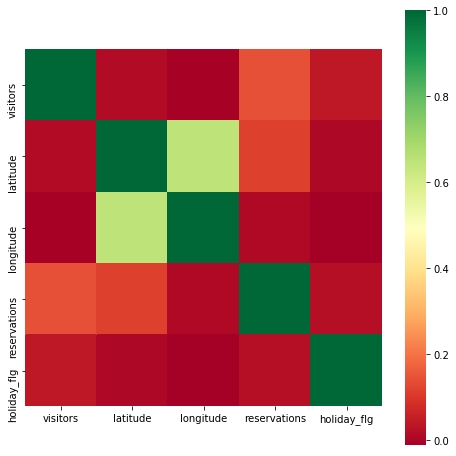

In [2]:
print('>>> df shape=', df.shape)
display(df.head(5))

# Plot correlation between different features
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')
plt.plot()
plt.show()

### 2.2 Correlation between `short_df` features

>>> short_df shape= (255917, 13)


,visitors,holiday_flg,reservations,year,month,day,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,25,0,-1.0,2016,1,13,0,0,0,0,0,0,1
1,32,0,-1.0,2016,1,14,0,0,0,0,1,0,0
2,29,0,-1.0,2016,1,15,1,0,0,0,0,0,0
3,22,0,-1.0,2016,1,16,0,0,1,0,0,0,0
4,6,0,-1.0,2016,1,18,0,1,0,0,0,0,0


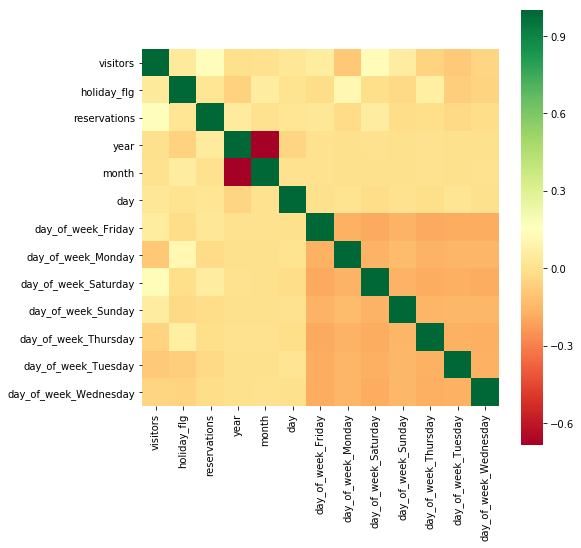

In [3]:
# Select which features are going to be used from the Dataframe
short_df = df[ ['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'holiday_flg', 'reservations'] ].copy()
#short_df = df[ ['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'holiday_flg'] ].copy()

short_df['year'] = df['visit_date'].dt.year
short_df['month'] = df['visit_date'].dt.month
short_df['day'] = df['visit_date'].dt.day
del short_df['visit_date']

# Delete restaurant's IDs
del short_df['air_store_id']

# Convert 'day_of_week' categorical feature into dummy variable
short_df = pd.get_dummies(short_df, columns=['day_of_week'])

print('>>> short_df shape=', short_df.shape)
display(short_df.head(5))

# Plot correlation between different features
plt.figure(figsize=(8, 8))
sns.heatmap(short_df.corr(), square=True, cmap='RdYlGn')
plt.plot()
plt.show()

# 3. Linear Regression

In [4]:
from sklearn.linear_model import LinearRegression

# karl: linear regression model using only the 'PTRATIO'
features = short_df.columns.values.tolist()
features.remove('visitors')
#print(features)

X = short_df[features]
y = short_df.visitors.values.reshape(-1, 1)

### 3.1 Cross-validation

Model performance is dependent on way the data is split and it does not represent well the model’s ability to generalize.

In [5]:
from sklearn.model_selection import cross_val_score
reg = LinearRegression() 
cv_results = cross_val_score(reg, X, y, cv=5) 
print('>>> CV results:', cv_results)
print('>>> CV mean:', np.mean(cv_results))

>>> CV results: [ 0.05369184  0.03764405  0.04168206  0.04457251  0.0330738 ]
>>> CV mean: 0.0421328524169


### 3.2 Split into train/test

In [6]:
# Split into train set, test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

### 3.3 Linear Regression on all features

In [7]:
# Fit the model to the data
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('>>> Intercept    =', reg.intercept_, '\n>>> Coefficients =', reg.coef_)
print('\n>>> Score:', reg.score(X_test, y_test))

>>> Intercept    = [ 719.45758339] 
>>> Coefficients = [[ 3.59565045  0.53220592 -0.34663272 -0.02583522  0.04805365  2.21544919
  -3.9007003   5.39456727  3.05214969 -2.07027267 -3.0998202  -1.59137298]]

>>> Score: 0.0586610243819


# 4. Regularized Regression

Linear regression minimizes a loss function. It chooses a coeﬃcient for each feature variable. Large coeﬃcients can lead to overﬁtting. Penalizing large coeﬃcients is called *regularization*.

### 4.1 Ridge

In [8]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1, normalize=False) 
ridge.fit(X_train, y_train) 
ridge_pred = ridge.predict(X_test) 
print('\n>>> Ridge Score:', ridge.score(X_test, y_test))


>>> Ridge Score: 0.0586610194931


### 4.2 Lasso

In [9]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, normalize=False) 
lasso.fit(X_train, y_train) 
lasso_pred = lasso.predict(X_test) 
lasso.score(X_test, y_test)

0.05609535516096209

#### 4.2.1 Lasso for feature selection 

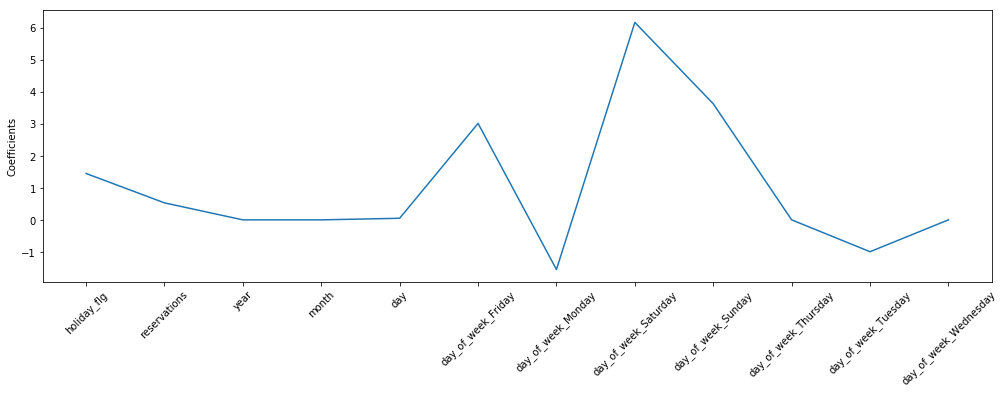

In [10]:
lasso = Lasso(alpha=0.1) 
lasso_coef = lasso.fit(X, y).coef_ 

plt.figure(figsize=(17,5))
plt.plot(range(len(features)), lasso_coef) 
plt.xticks(range(len(features)), features, rotation=45) 
plt.ylabel('Coefficients') 
plt.show()